In [1]:
import pandas as pd
from pandas import json_normalize
import requests
import json
from datetime import datetime
from datetime import timezone
import re 
from unidecode import unidecode

"INTEGRAR API SPOTIFY"

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


<h1><center>DESCARGA TU PROPIA INFORMACIÓN</center></h1>

En este Notebook podrás descargar tu información spotify para su posterior análisis. Recuerda que, para poder utilizar estas credenciales, es necesario que previamente te comuniques con el autor para recibir los permisos para ejecutarla. En caso de que poseas credenciales propias para poder acceder a la API de spotify, puedes modificar el código para que funcione directamente con ellas[1]. 

Se han incluido algunas otras métricas de interés que podrían resultar en un análisis más robusto de la persona. Son varias las herramientas estadísticas para poder analizar este tipo de valores contínuos y nomináles. Dado que el proyecto está orientado al análisis de textos, __solamente se hará uso del nombre del autor y del nombre de la canción__ en un principio. 

Se utiliza la API [Lyrics OVH](https://lyricsovh.docs.apiary.io/#) para la obtención de la letra de cada canción. Es de uso libre y gratuíto y por tanto, habrá casos en los que no pueda recuperarse la letra de algunas canciones. 



[1]: Desafortunadamente no se me concedió el permiso.

# Credenciales

El proyecto está resguardado en un repositorio propio del autor. Por lo tanto, es necesario que pidas permiso para ser agregado a este. La única modificación que necesitas realizar es en el campo `username`. 

__NOTA__: Al pedir permiso envía al correo montanodavid780@gmail.com tu nombre de usuario de spotify y el correo con el que estás registrado.
    
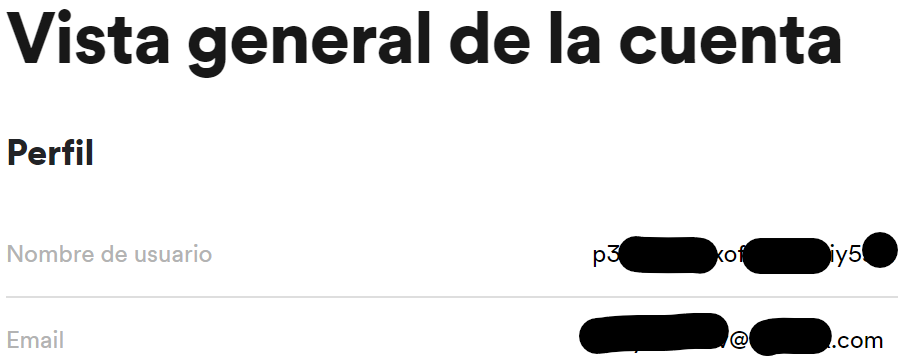

In [2]:
cid = "dc74a8f0df534595ba93220a083618f2"
secret = "291e585936b946a89fdbffebfa2dff31" 
username = "p3zvjj8be7xofm13eqaiy5srh" # <---- Aquí introduce tu nombre de username
redirect_uri = "https://localhost:8080"

# Primer filtro (50 s - 120 s)

In [3]:
%%time
scope = "user-top-read"
token = util.prompt_for_user_token(username,scope,cid,secret,redirect_uri)
sp = spotipy.Spotify(auth = token)


top = sp.current_user_top_tracks(time_range = "short_term", limit = 50)


indf_crudo = json_normalize(top["items"]).drop(columns = ["available_markets","disc_number","explicit","href","popularity","is_local","preview_url",
                                                   "track_number","uri","album.album_type","album.artists","type","album.available_markets",
                                                   "album.external_urls.spotify","album.href","album.id","album.images","album.release_date_precision",
                                                   "album.total_tracks","album.type","album.uri","external_ids.isrc","external_urls.spotify"])

artist = []
for i in range(indf_crudo.shape[0]):
    artist.append(indf_crudo["artists"][i][0]["name"])
    
indf = indf_crudo.copy()
indf["artists"] = artist

features = pd.DataFrame(indf["id"].apply(lambda x: sp.audio_features(x)[0]).to_list()).iloc[:,:13].drop(columns = "type")


base = pd.merge(indf,features, how = "left", on = "id")



def find_lyrics(df):
    dic = df[["artists","name"]].to_dict()
    
    artistas = dic["artists"]
    canciones = dic["name"]
    
    lyrics = []
    for i in range(df.shape[0]):
        autor = artistas[i]
        cancion = canciones[i]
        
        print(i)
        print(autor)
        print(cancion)
        print("---", 2*"\n")
        
        
        try:
            r = requests.get("https://api.lyrics.ovh/v1/{}/{}".format(autor,cancion))
            
            if "lyrics" in list(r.json().keys())[0]: 
                lyrics.append(r.json()["lyrics"])
            else:
                lyrics.append("")
        
        except:
            lyrics.append("error") 
            
    df["lyrics"] = lyrics
    
    

find_lyrics(base)

0
CKay
love nwantiti (feat. Dj Yo! & AX'EL) - Remix
--- 


1
J Balvin
Si Tu Novio Te Deja Sola
--- 


2
Natalia Lafourcade
Amor, Amor de Mis Amores (with Devendra Banhart)
--- 


3
GIMS
Reste
--- 


4
León Larregui
Femme Fatal
--- 


5
Queen
Love Of My Life - Remastered 2011
--- 


6
León Larregui
Mar
--- 


7
León Larregui
Resguardum Ether
--- 


8
Los Amigos Invisibles
Viviré para Ti
--- 


9
Wisin
Escápate Conmigo (feat. Ozuna)
--- 


10
Natalia Lafourcade
Soledad y el Mar (feat. Los Macorinos)
--- 


11
Café Tacvba
Avientame
--- 


12
Arctic Monkeys
Star Treatment
--- 


13
Vaults
One Last Night
--- 


14
Camilo
Índigo
--- 


15
Romeo Santos
Yo También (feat. Marc Anthony)
--- 


16
Grover Washington, Jr.
Just the Two of Us
--- 


17
Arctic Monkeys
Tranquility Base Hotel & Casino
--- 


18
Bee Gees
More Than A Woman - From "Saturday Night Fever" Soundtrack
--- 


19
Pitbull
Fireball (feat. John Ryan)
--- 


20
IAmChino
Ay Mi Dios
--- 


21
León Larregui
Brillas - Love La Femme
--- 

# Segundo filtro (15 s - 90 s)

En ocasiones, algunos nombres de artístas o de canciones contienen carácteres que la API que provee las canciones no puede procesar. Es por eso que podría aplicarse un segundo filtro en caso de querer intentar nuevamente la busqueda pero aplicando una determinada limpieza en los nombres a fín de "robustecer" la base.

In [4]:
%%time
try_base = base[(base["lyrics"] == "") | (base["lyrics"] == "error")].reset_index()

try_base.loc[try_base.name.str.extract(r"(.+(?=( -| \()))")[0].dropna().index,"name"] = try_base.name.str.extract(r"(.+(?=( -| \()))")[0].dropna() # Reemplaza los nombres

find_lyrics(try_base) # Encuentra canciones

try_base.set_index("index", inplace = True) # Regresa Indices originales

base.loc[try_base.index, ["name","lyrics"]] = try_base[["name","lyrics"]] # Pega a la base original

base["album.release_date"] = base["album.release_date"].apply(lambda x: x[:4]) # Extrae año

0
CKay
love nwantiti (feat. Dj Yo! & AX'EL)
--- 


1
Natalia Lafourcade
Amor, Amor de Mis Amores
--- 


2
GIMS
Reste
--- 


3
Queen
Love Of My Life
--- 


4
Los Amigos Invisibles
Viviré para Ti
--- 


5
Natalia Lafourcade
Soledad y el Mar
--- 


6
Grover Washington, Jr.
Just the Two of Us
--- 


7
Arctic Monkeys
Tranquility Base Hotel & Casino
--- 


8
Bee Gees
More Than A Woman
--- 


9
León Larregui
Brillas
--- 


10
Café Tacvba
Una mañana
--- 


11
Tainy
Lo Siento BB:/
--- 


12
Bee Gees
How Deep Is Your Love
--- 


13
Jarabe De Palo
La chica de Ipanema
--- 


14
Los Amigos Invisibles
Espérame Feat. Elastic Bond
--- 


15
Bee Gees
Night Fever
--- 


16
Los Amigos Invisibles
La Que Me Gusta
--- 


17
Zoé
Poli / Love
--- 


18
Stacey Kent
La vénus du mélo
--- 


19
León Larregui
Como Tú
--- 


20
Tainy
A Mi También ft. Alvaro Diaz, Feid
--- 


Wall time: 28.6 s


---

# Guarda tu base en formato CSV
Puedes utilizar cualquier nombre para el archivo. Yo te sugiero primero __borres todas las letras en rojo y pongas tu nombre__. Después de esto, solo aloja el documento junto a los dos archivos para proceder con el análisis o en su defecto, necesitarás la ruta de la ubicación de tu documento. 

In [6]:
tu_nombre = "Aquí escribe tu primer nombre en minúsculas" # david
#base.to_csv(f"top_{tu_nombre}_spotify.csv")